Stand: 02.03.25

### Fragestellung: Gibt es andere DWD-Messstellen in der Nähe von Konstanz

1) Herausfinden welche Messstellen relevant sein könnten
2) Vergleichen der Werte mit Konstanz -> sieht man einen Unterschied beim Wechsel des Standortes ab dem 19.10.2020?

In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO, BytesIO
import locale
from bokeh.palettes import Viridis
import zipfile
import matplotlib.pyplot as plt

locale.setlocale(locale.LC_ALL, 'deu_deu')

'German_Germany.1252'

### 1 a) Einlesen der DWD-Datei über die Messstationen

In [2]:
url_stationen = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/TU_Stundenwerte_Beschreibung_Stationen.txt'

# Datei laden
response = requests.get(url_stationen)
text = response.content.decode('latin1')  # Wichtig wegen Sonderzeichen!

# In StringIO-Objekt (pseudo-Datei) packen
file_like = StringIO(text)

# Spaltenbreiten definieren (manuell basierend auf Dateistruktur)
colspecs = [
    (0, 5),        # Stations_id
    (6, 14),       # von_datum
    (15, 24),      # bis_datum
    (25, 38),      # Stationshoehe
    (39, 51),      # geoBreite
    (52, 60),      # geoLaenge
    (61, 101),     # Stationsname
    (102, 123),    # Bundesland
    (124, 150)     # Abgabe
]

stationen_df = pd.read_fwf(file_like, colspecs=colspecs, skiprows=2, header=None)
# DataFrame laden mit festen Spaltenbreiten

# Spaltennamen setzen
stationen_df.columns = ['Stations_id', 'von_datum', 'bis_datum', 'Stationshoehe',
              'geoBreite', 'geoLaenge', 'Stationsname', 'Bundesland', 'Abgabe']

# Datentypen anpassen (optional)
stationen_df['von_datum'] = pd.to_datetime(stationen_df['von_datum'], format='%Y%m%d', errors='coerce')
stationen_df['bis_datum'] = pd.to_datetime(stationen_df['bis_datum'], format='%Y%m%d', errors='coerce')
stationen_df['Stationshoehe'] = pd.to_numeric(stationen_df['Stationshoehe'], errors='coerce')
stationen_df['geoBreite'] = pd.to_numeric(stationen_df['geoBreite'], errors='coerce')
stationen_df['geoLaenge'] = pd.to_numeric(stationen_df['geoLaenge'], errors='coerce')
stationen_df.drop('Abgabe', axis=1, inplace=True)

# Ergebnis
display(stationen_df.head())


,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,3,1950-04-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,44,2007-04-01,2025-03-01,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,52,1976-01-01,1988-01-01,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
3,71,2009-12-01,2019-12-31,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
4,73,2007-04-01,2025-03-01,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern


### 1 b) Filtern des DataFrames nach relevanten stationen

- sortieren nach Entfernung
- filtern nach dem Zeitraum -> wo sind Daten vom 01.01.2017 bis 13.12.2024 
- filtern nach ähnlicher Stationshöhe von 428 m

In [3]:
"""
    Berechnung und sortieren nach der Entfernung zu Konstanz
"""

# Daten Messstation DWD Konstanz:
ziel_station = stationen_df[stationen_df["Stationsname"] == "Konstanz"]

ziel_lat = ziel_station['geoBreite'].values[0]
ziel_lon = ziel_station['geoLaenge'].values[0]

# Haversine-Formel definieren
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Erdradius in km
    return c * r

# Entfernung berechnen und neue Spalte hinzufügen
stationen_df['Entfernung_km'] = stationen_df.apply(
    lambda row: haversine(ziel_lat, ziel_lon, row['geoBreite'], row['geoLaenge']),
    axis=1
)

# Sortieren nach Entfernung
stationen_df = stationen_df.sort_values('Entfernung_km')



"""
    Filtern nach dem Datum

"""

start = pd.Timestamp('2017-01-01')
ende = pd.Timestamp('2024-12-31')

relevant_stations = stationen_df[
    (stationen_df['von_datum'] <= start) & 
    (stationen_df['bis_datum'] >= ende)
]

"""
    Filtern nach Stationshöhe

"""

ziel_hoehe = ziel_station["Stationshoehe"].values[0]

relevant_stations = relevant_stations[
    (stationen_df['Stationshoehe'] <= ziel_hoehe + 80) & 
    (stationen_df['Stationshoehe'] >= ziel_hoehe - 80)
    ]

# Ergebnis anzeigen
display(relevant_stations.head(5))

C:\Users\majaf\AppData\Local\Temp\ipykernel_10744\2521324320.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_stations = relevant_stations[


,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Entfernung_km
268,2712,1971-01-01,2025-03-01,428,47.6952,9.1307,Konstanz,Baden-Württemberg,0.000000
582,6258,2003-01-01,2025-03-01,461,47.6845,9.4409,Friedrichshafen-Unterraderach,Baden-Württemberg,23.248964
586,6263,2004-07-01,2025-03-01,445,47.7738,8.8219,Singen,Baden-Württemberg,24.692402
405,4094,2004-06-01,2025-03-01,441,47.8062,9.6206,"Weingarten, Kr. Ravensburg",Baden-Württemberg,38.649952
458,4704,2005-05-01,2025-03-01,508,47.5776,9.7404,Sigmarszell-Zeisertsweiler,Bayern,47.517441


### 2) Vergleichen der Werte mit Konstanz
- herunterladen der anderen Werte
- vergleichen mit Konstanz

In [4]:
station_id = "06258"
start_jahr = 2017
end_jahr = 2024
n_years = 1 + (end_jahr - start_jahr)
#[*Turbo256[0:n_years]]; [*RdYlBu[n_years]]
color_list = [*Viridis[n_years]]


url_akt = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_{station_id}_20030101_20231231_hist.zip'

def get_meteo_data(url):
    # lädt ZIP-Datei von der URL
    dwd_zip = requests.get(url)
    # öffnet Zip-Datei im Speicher
    # BytesIO -> die im Speicher gespeicherten Bytes werden behandelt, als wären sie eine Datei
    archiv= zipfile.ZipFile(BytesIO(dwd_zip.content))
    # Liste aller Dateinamen in der ZIP-Datei
    filelist = archiv.namelist()
    filterlist= [x for x in filelist if 'produkt_klima_tag' in x]
    print(f"Gefundene Datei: {filterlist[0]}")
    # type: bytes -> sieht aus wie ein langer String, wo alles hintereinander geschrieben wurde mit ; und eor\r\n für neue Zeile
    csvdata = archiv.read(filterlist[0]) 
    data = pd.read_csv(BytesIO(csvdata), sep=';', encoding='utf-8').set_index('MESS_DATUM')
    data.columns = [name.strip() for name in data.columns] # Leerzeichen aus Spaltennamen entfernen
    return data

dwd_akt = get_meteo_data(url_akt)
dwd_hist = get_meteo_data(url_hist)

display(dwd_akt.head())
display(dwd_hist.head())

# DataFrames werden untereinander zusammengefügt; Index von beiden wird behalten
# durch keys wird ein Multiindex erzeugt, damit man sieht aus welcher Quelle die Daten komme
dwd = pd.concat([dwd_hist, dwd_akt], ignore_index=False, keys=['dwd_hist', 'dwd_akt'])
# Multiindices werden zu Spalten: level_0 und MESS_DATUM -> die Duplikate aus MESS_DATUM werden entfernt
# die Spalte mit den keys von davor, wird SOURCE genannt
dwd = dwd.reset_index().rename(columns={'level_0': 'SOURCE'}).drop_duplicates(subset='MESS_DATUM', keep='first')

# Datumsformat setzten
dwd['MESS_DATUM'] = pd.to_datetime(dwd['MESS_DATUM'], format='%Y%m%d')

dwd.replace(to_replace=-999, value = np.nan, inplace=True)

dwd = dwd.set_index(["MESS_DATUM"])

dwd_Friedrichshafen = dwd.copy()
display(dwd_Friedrichshafen.head())

Gefundene Datei: produkt_klima_tag_20230830_20250301_06258.txt
Gefundene Datei: produkt_klima_tag_20030101_20231231_06258.txt


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
20230830,6258,-999,-999,-999,10,1.2,4,5.9,-999,-999,13.6,-999,15.1,80.0,19.4,11.5,10.2,eor
20230831,6258,-999,-999,-999,10,0.2,4,1.9,-999,-999,13.5,-999,15.5,77.0,18.5,12.6,12.3,eor
20230901,6258,-999,-999,-999,10,0.0,0,10.8,-999,-999,15.4,-999,19.2,71.0,24.7,15.0,12.7,eor
20230902,6258,-999,-999,-999,10,0.0,0,12.6,-999,-999,16.3,-999,20.1,71.0,27.2,13.6,11.2,eor
20230903,6258,-999,-999,-999,10,0.0,0,10.6,-999,-999,17.1,-999,20.0,74.0,26.5,14.5,11.9,eor


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
20030101,6258,-999,-999,-999,10,1.7,4,-999.0,0,6.0,8.2,-999,7.4,81.0,9.9,5.7,3.3,eor
20030102,6258,-999,-999,-999,10,11.8,4,-999.0,0,6.3,10.0,-999,10.5,79.0,13.8,7.4,5.7,eor
20030103,6258,-999,-999,-999,10,8.5,4,-999.0,0,6.7,7.3,-999,8.1,68.0,10.2,6.0,4.6,eor
20030104,6258,-999,-999,-999,10,5.2,4,-999.0,0,8.0,8.2,-999,5.8,89.0,7.5,1.7,1.0,eor
20030105,6258,-999,-999,-999,10,1.5,4,0.0,0,8.0,4.8,-999,-1.6,85.0,1.7,-3.4,-5.1,eor


,SOURCE,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,,
2003-01-01,dwd_hist,6258,NaN,NaN,NaN,10,1.7,4.0,NaN,0.0,6.0,8.2,NaN,7.4,81.0,9.9,5.7,3.3,eor
2003-01-02,dwd_hist,6258,NaN,NaN,NaN,10,11.8,4.0,NaN,0.0,6.3,10.0,NaN,10.5,79.0,13.8,7.4,5.7,eor
2003-01-03,dwd_hist,6258,NaN,NaN,NaN,10,8.5,4.0,NaN,0.0,6.7,7.3,NaN,8.1,68.0,10.2,6.0,4.6,eor
2003-01-04,dwd_hist,6258,NaN,NaN,NaN,10,5.2,4.0,NaN,0.0,8.0,8.2,NaN,5.8,89.0,7.5,1.7,1.0,eor
2003-01-05,dwd_hist,6258,NaN,NaN,NaN,10,1.5,4.0,0.0,0.0,8.0,4.8,NaN,-1.6,85.0,1.7,-3.4,-5.1,eor


In [5]:
station_id = "06263"
start_jahr = 2017
end_jahr = 2024
n_years = 1 + (end_jahr - start_jahr)
#[*Turbo256[0:n_years]]; [*RdYlBu[n_years]]
color_list = [*Viridis[n_years]]


url_akt = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_{station_id}_20040701_20231231_hist.zip'

def get_meteo_data(url):
    # lädt ZIP-Datei von der URL
    dwd_zip = requests.get(url)
    # öffnet Zip-Datei im Speicher
    # BytesIO -> die im Speicher gespeicherten Bytes werden behandelt, als wären sie eine Datei
    archiv= zipfile.ZipFile(BytesIO(dwd_zip.content))
    # Liste aller Dateinamen in der ZIP-Datei
    filelist = archiv.namelist()
    filterlist= [x for x in filelist if 'produkt_klima_tag' in x]
    print(f"Gefundene Datei: {filterlist[0]}")
    # type: bytes -> sieht aus wie ein langer String, wo alles hintereinander geschrieben wurde mit ; und eor\r\n für neue Zeile
    csvdata = archiv.read(filterlist[0]) 
    data = pd.read_csv(BytesIO(csvdata), sep=';', encoding='utf-8').set_index('MESS_DATUM')
    data.columns = [name.strip() for name in data.columns] # Leerzeichen aus Spaltennamen entfernen
    return data

dwd_akt = get_meteo_data(url_akt)
dwd_hist = get_meteo_data(url_hist)

display(dwd_akt.head())
display(dwd_hist.head())

# DataFrames werden untereinander zusammengefügt; Index von beiden wird behalten
# durch keys wird ein Multiindex erzeugt, damit man sieht aus welcher Quelle die Daten komme
dwd = pd.concat([dwd_hist, dwd_akt], ignore_index=False, keys=['dwd_hist', 'dwd_akt'])
# Multiindices werden zu Spalten: level_0 und MESS_DATUM -> die Duplikate aus MESS_DATUM werden entfernt
# die Spalte mit den keys von davor, wird SOURCE genannt
dwd = dwd.reset_index().rename(columns={'level_0': 'SOURCE'}).drop_duplicates(subset='MESS_DATUM', keep='first')

# Datumsformat setzten
dwd['MESS_DATUM'] = pd.to_datetime(dwd['MESS_DATUM'], format='%Y%m%d')

dwd.replace(to_replace=-999, value = np.nan, inplace=True)

dwd = dwd.set_index(["MESS_DATUM"])

dwd_Singen = dwd.copy()
display(dwd_Singen.head())

Gefundene Datei: produkt_klima_tag_20230830_20250301_06263.txt
Gefundene Datei: produkt_klima_tag_20040701_20231231_06263.txt


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
20230830,6263,-999,-999,-999,10,0.7,4,-999,-999,-999,13.5,-999,14.2,85.0,20.0,11.0,10.4,eor
20230831,6263,-999,-999,-999,10,1.0,4,-999,-999,-999,13.3,-999,15.2,78.0,19.0,12.0,11.5,eor
20230901,6263,-999,-999,-999,10,0.0,0,-999,-999,-999,15.3,-999,18.3,74.0,25.5,12.8,12.0,eor
20230902,6263,-999,-999,-999,10,0.0,0,-999,-999,-999,16.2,-999,19.2,76.0,28.1,11.1,9.8,eor
20230903,6263,-999,-999,-999,10,0.0,0,-999,-999,-999,16.9,-999,19.7,75.0,27.0,12.2,10.9,eor


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
20040701,6263,-999,-999,-999,10,2.5,4,-999,0,7.7,11.8,-999,16.6,64.0,22.5,10.6,9.1,eor
20040702,6263,-999,-999,-999,10,1.3,4,-999,0,5.7,11.6,-999,15.6,68.0,21.4,11.0,9.7,eor
20040703,6263,-999,-999,-999,10,0.0,0,-999,0,6.0,10.6,-999,15.8,62.0,22.0,10.1,9.2,eor
20040704,6263,-999,-999,-999,10,0.0,0,-999,0,0.7,10.9,-999,17.4,59.0,25.6,7.7,6.3,eor
20040705,6263,-999,-999,-999,10,6.2,4,-999,0,7.0,14.8,-999,17.6,75.0,25.3,10.1,8.8,eor


,SOURCE,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,,
2004-07-01,dwd_hist,6263,NaN,NaN,NaN,10,2.5,4,NaN,0.0,7.7,11.8,NaN,16.6,64.0,22.5,10.6,9.1,eor
2004-07-02,dwd_hist,6263,NaN,NaN,NaN,10,1.3,4,NaN,0.0,5.7,11.6,NaN,15.6,68.0,21.4,11.0,9.7,eor
2004-07-03,dwd_hist,6263,NaN,NaN,NaN,10,0.0,0,NaN,0.0,6.0,10.6,NaN,15.8,62.0,22.0,10.1,9.2,eor
2004-07-04,dwd_hist,6263,NaN,NaN,NaN,10,0.0,0,NaN,0.0,0.7,10.9,NaN,17.4,59.0,25.6,7.7,6.3,eor
2004-07-05,dwd_hist,6263,NaN,NaN,NaN,10,6.2,4,NaN,0.0,7.0,14.8,NaN,17.6,75.0,25.3,10.1,8.8,eor


In [6]:
station_id = "02712"
start_jahr = 2017
end_jahr = 2024
n_years = 1 + (end_jahr - start_jahr)
#[*Turbo256[0:n_years]]; [*RdYlBu[n_years]]
color_list = [*Viridis[n_years]]


url_akt = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_{station_id}_19590701_20231231_hist.zip'

def get_meteo_data(url):
    # lädt ZIP-Datei von der URL
    dwd_zip = requests.get(url)
    # öffnet Zip-Datei im Speicher
    # BytesIO -> die im Speicher gespeicherten Bytes werden behandelt, als wären sie eine Datei
    archiv= zipfile.ZipFile(BytesIO(dwd_zip.content))
    # Liste aller Dateinamen in der ZIP-Datei
    filelist = archiv.namelist()
    filterlist= [x for x in filelist if 'produkt_klima_tag' in x]
    print(f"Gefundene Datei: {filterlist[0]}")
    # type: bytes -> sieht aus wie ein langer String, wo alles hintereinander geschrieben wurde mit ; und eor\r\n für neue Zeile
    csvdata = archiv.read(filterlist[0]) 
    data = pd.read_csv(BytesIO(csvdata), sep=';', encoding='utf-8').set_index('MESS_DATUM')
    data.columns = [name.strip() for name in data.columns] # Leerzeichen aus Spaltennamen entfernen
    return data

dwd_akt = get_meteo_data(url_akt)
dwd_hist = get_meteo_data(url_hist)

display(dwd_akt.head())
display(dwd_hist.head())

# DataFrames werden untereinander zusammengefügt; Index von beiden wird behalten
# durch keys wird ein Multiindex erzeugt, damit man sieht aus welcher Quelle die Daten komme
dwd = pd.concat([dwd_hist, dwd_akt], ignore_index=False, keys=['dwd_hist', 'dwd_akt'])
# Multiindices werden zu Spalten: level_0 und MESS_DATUM -> die Duplikate aus MESS_DATUM werden entfernt
# die Spalte mit den keys von davor, wird SOURCE genannt
dwd = dwd.reset_index().rename(columns={'level_0': 'SOURCE'}).drop_duplicates(subset='MESS_DATUM', keep='first')

# Datumsformat setzten
dwd['MESS_DATUM'] = pd.to_datetime(dwd['MESS_DATUM'], format='%Y%m%d')

dwd.replace(to_replace=-999, value = np.nan, inplace=True)

dwd = dwd.set_index(["MESS_DATUM"])

dwd_Konstanz = dwd.copy()
display(dwd_Konstanz.head())

Gefundene Datei: produkt_klima_tag_20230830_20250301_02712.txt
Gefundene Datei: produkt_klima_tag_19590701_20231231_02712.txt


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
20230830,2712,10,6.5,1.6,9,1.3,6,5.9,0,6.0,12.9,960.9,14.9,77.0,20.4,11.4,10.8,eor
20230831,2712,10,8.0,2.8,9,0.2,6,1.8,0,7.9,13.0,965.2,15.7,74.0,18.5,13.1,12.1,eor
20230901,2712,10,9.4,1.8,9,0.0,0,9.6,0,5.4,14.8,967.1,19.0,69.0,25.3,13.8,12.8,eor
20230902,2712,10,4.9,1.4,9,0.0,0,12.4,0,5.3,15.8,970.4,19.4,73.0,27.6,12.2,11.3,eor
20230903,2712,10,5.9,1.6,9,0.0,0,10.2,0,6.8,16.9,975.2,20.0,74.0,26.8,13.1,12.0,eor


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
19590701,2712,5,11.8,4.3,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590702,2712,5,8.8,3.7,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590703,2712,5,14.2,2.3,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590704,2712,5,5.2,1.8,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590705,2712,5,4.4,1.0,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor


,SOURCE,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,,
1959-07-01,dwd_hist,2712,5,11.8,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eor
1959-07-02,dwd_hist,2712,5,8.8,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eor
1959-07-03,dwd_hist,2712,5,14.2,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eor
1959-07-04,dwd_hist,2712,5,5.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eor
1959-07-05,dwd_hist,2712,5,4.4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eor


!! Bisher sind es hier nur tägliche Werte vom DWD -> besser wären Stundenwerte und dann je ein Diagramm für Tag und Nacht miteinder vergleichen

Am 19.10.2020 war der Standortwechsel -> man sieht, dass davor häufiger Spitzen bei Konstanz waren 

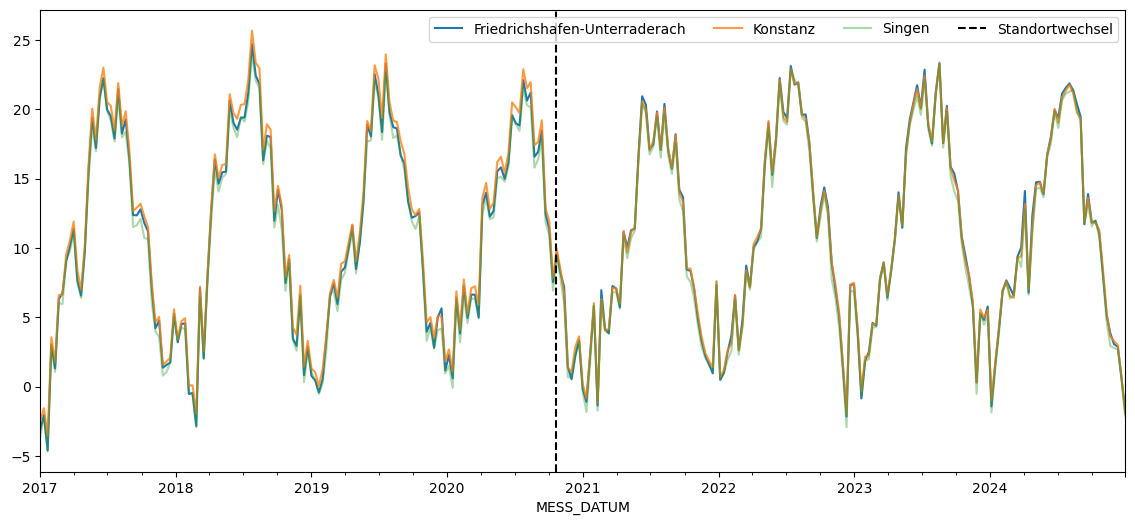

In [19]:
start = "2017"
ende = "2024"
dwd_Friedrichshafen["TMK"].loc[start:ende].resample("10D").mean().plot(label = "Friedrichshafen-Unterraderach")
dwd_Konstanz["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label ="Konstanz",alpha=0.8)
dwd_Singen["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label ="Singen",alpha=0.4)
plt.axvline(pd.Timestamp("2020-10-19"), color="black", linestyle="--", label="Standortwechsel")

plt.legend(ncol=4)